# Anticipez les besoins en consommation électrique de bâtiments
## Notebook Modélisations
### Sommaire :
- [A - Préparation des données](#A)
- [B - Preprocessing](#B)
- [C - Modélisation](#C)
    - [C.1 - Madèle Baseline : Dummy Regressor ](#C.1)
    - [C.2 - Regression Linéaire](#C.2)
    - [C.3 - Régression Ridge](#C.3)
    - [C.4 - Régression Lasso](#C.4)
    - [C.5 - ElasticNet](#C.5)
- [D - Méthodes Ensemblistes](#D)
    - [D.1 - Bagging](#D.1)
    - [D.2 - RandomForest](#D.2)
    - [D.3 - Gradient Boosting](#D.3)
- [E - Comparaison des différents modèles](#E)
    - [E.1 - Score R2 & RMSE](#E.1)
    - [E.2 - Performances matérielles](#E.2)
- [F - Feature importance](#F)
- [G - Performances sans l'ENERGYSTARScore](#G)

In [1]:
%matplotlib inline  
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import seaborn as sns
import time

In [2]:
pd.options.display.max_columns = 200

In [3]:
t_start = time.time()

In [4]:
from sklearn.model_selection import train_test_split

Fonctions personnalisées :

In [5]:
def recap(df):
    return pd.concat([df.describe(include='all'), df.dtypes.to_frame(name='type').T])
#on créer une fonction qui renvoie un dataframe contenant les différentes modalités d'une colonne ainsi que le nombre de fois
#qu'elles apparaissent ainsi que leur fréquence d'apparition
def moda(df,col):
    eff = df[col].value_counts() #on comptes le nombre de valeurs dans la colonne
    moda = eff.index #on récupères les modalités que prends la variable

    tabModa = pd.DataFrame(moda, columns = [col]) #on crée un DataFrame avec toutes les modalités de la variable
    tabModa["n"] = eff.values #On ajoute une colonne au DataFrame contenant le nombre d'occurence de la modalité
    tabModa["f"] = tabModa["n"]/sum(tabModa["n"])*100 #on ajoute une colonne au DataFrame colculant la fréquence d'apparition de la modalité
    return tabModa

def colNan(df, sort=False):
    colNull=df.isnull().sum()
    colTabNul = pd.DataFrame(colNull, columns=["Nb Null"]) 
    colTabNul["% Null"] = colTabNul["Nb Null"]/len(df)*100
    if sort==False:
        return colTabNul
    else:
        return colTabNul.sort_values(by = 'Nb Null', ascending = False)

# fonction qui renvoies le nb de données manquantes d'une colonne d'un dataframe ainsi que sa fréquence
def nbNaCol(df, col):
    size=df[df[col].isna()==True].shape
    return size[0], size[0]/len(df)*100

def pieplot(df,col):
    return plt.pie(df["n"], labels=df[col], explode=[0.1]*len(df), normalize = True, autopct="%.1f%%")

def diagbar(df,col):
    plt.figure(figsize=(10,5))
    bp=sns.barplot(x=df[col],y=df['f'],palette='Spectral')
    bp.set_xticklabels(labels=df[col],rotation=90)
    plt.show()

def nbinsYule(d):
    return int(2.5*(len(d.isna()==False))**(1/4))

def hist_comp(df,col):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12,5))
    sns.histplot(data=df[col],bins=nbinsYule(df[col]), kde=True, ax=axes[0])
    axes[0].set_title("Données initiales", color='#2cb7b0')
    sns.histplot(data=np.log(df[col][df[col]>0]), kde=True, ax=axes[1])
    axes[1].set_title("Application du logarithme", color='#2cb7b0')
    title="Distribution de "+col+" avec changement d'échelle"
    plt.suptitle(title, fontsize=12)
    plt.show()

# A- Préparation des données <a name=A ></a>

In [2]:
data = pd.read_csv("Data/data.csv")

In [7]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Latitude,Longitude,Neighborhood,YearBuilt,BuildingAge,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFATotal_log,PropertyGFAParking,ParkingProp,PropertyGFABuilding(s),BuildingProp,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,TopUseTypeProp,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,405 OLIVE WAY,SEATTLE,WA,98101.0,659000030,7,47.612190,-122.337997,DOWNTOWN,1927,88,1.0,12.0,88434,11.390012,0,0.000000,88434,100.000000,HOTEL,HOTEL,88434.0,100.000000,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,249.43,2.64,No,NaN,Compliant,NaN
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,724 PINE ST,SEATTLE,WA,98101.0,659000220,7,47.613106,-122.333358,DOWNTOWN,1996,19,1.0,11.0,103566,11.547964,15064,14.545314,88502,85.454686,"HOTEL, PARKING, RESTAURANT",HOTEL,83880.0,80.991831,PARKING,15064.0,RESTAURANT,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,263.51,2.38,No,NaN,Compliant,NaN
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,1900 5TH AVE,SEATTLE,WA,98101.0,659000475,7,47.613349,-122.337699,DOWNTOWN,1969,46,1.0,41.0,961990,13.776759,0,0.000000,961990,100.000000,"HOTEL, PARKING, SWIMMING POOL",HOTEL,757243.0,78.716307,PARKING,100000.0,SWIMMING POOL,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,2061.48,1.92,Yes,NaN,Compliant,NaN
3,5,2015,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,SEATTLE,WA,98101.0,659000640,7,47.614216,-122.336609,DOWNTOWN,1926,89,1.0,10.0,61320,11.023861,0,0.000000,61320,100.000000,HOTEL,HOTEL,61320.0,100.000000,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,1936.34,31.38,No,NaN,Compliant,High Outlier
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,401 LENORA ST,SEATTLE,WA,98121.0,659000970,7,47.613754,-122.340924,DOWNTOWN,1980,35,1.0,18.0,119890,11.694330,12460,10.392860,107430,89.607140,"HOTEL, PARKING, SWIMMING POOL",HOTEL,123445.0,100.000000,PARKING,68009.0,SWIMMING POOL,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,507.70,4.02,No,NaN,Compliant,NaN


In [8]:
len(data[data['DataYear']==2015])

1639

In [9]:
len(data[data['DataYear']==2015])/len(data)

0.4986309704898083

In [10]:
len(data[data['DataYear']==2016])

1648

In [11]:
len(data[data['DataYear']==2016])/len(data)

0.5013690295101917

In [12]:
len(data)

3287

In [13]:
len(data)/6716

0.4894282310899345

## Allégement du DataSet
On va alléger le DataSet en retirant les variables :
   - Qui concernent les relevé : en effet, le but est de se passer de ces relevés à l'avenir
   - Qui sont liés d'une manière ou d'une autre à une autre variable 
   - Qui ne varient pas 

In [14]:
df=data.drop(columns=['City', 'State','ZipCode','YearBuilt','PropertyGFAParking','PropertyGFABuilding(s)','ListOfAllPropertyUseTypes',
                   'LargestPropertyUseTypeGFA','SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA',
                   'ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA','YearsENERGYSTARCertified','SiteEUI(kBtu/sf)',
                    'SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)','SteamUse(kBtu)',
                    'Electricity(kWh)','Electricity(kBtu)','NaturalGas(therms)','NaturalGas(kBtu)','GHGEmissionsIntensity(kgCO2e/ft2)',
                     'DefaultData','Comment','ComplianceStatus','Outlier'])

In [15]:
colNan(df)

,Nb Null,% Null
OSEBuildingID,0,0.000000
DataYear,0,0.000000
BuildingType,0,0.000000
PrimaryPropertyType,0,0.000000
PropertyName,0,0.000000
Address,0,0.000000
TaxParcelIdentificationNumber,1,0.030423
CouncilDistrictCode,0,0.000000
Latitude,0,0.000000
Longitude,0,0.000000


In [16]:
#On isole les variables d'identification
idVar = ['OSEBuildingID','DataYear','PropertyName','Address','TaxParcelIdentificationNumber']
data_id = df[idVar]
df=df.drop(columns=idVar)

In [17]:
df.shape

(3287, 18)

## Séparation Features-Target :

In [18]:
y = df[['SiteEnergyUse(kBtu)','TotalGHGEmissions(MetricTonsCO2e)']]
X = df.drop(columns=y.columns)

### Retrait des features trés corrélées entre-elles

<AxesSubplot:>

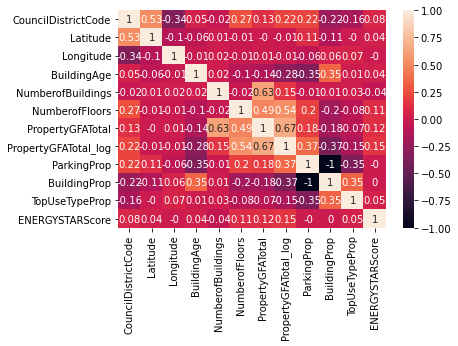

In [19]:
matrice_corr = X.corr().round(2)
sns.heatmap(data=matrice_corr, annot=True)

On remarque que "ParkingProp" est corrélée à "BuildingProp" avec un coeff de corrélation de "-1". nous allons donc retirer "ParkingProp" des features :

In [20]:
X = X.drop(columns=['ParkingProp'])

<AxesSubplot:>

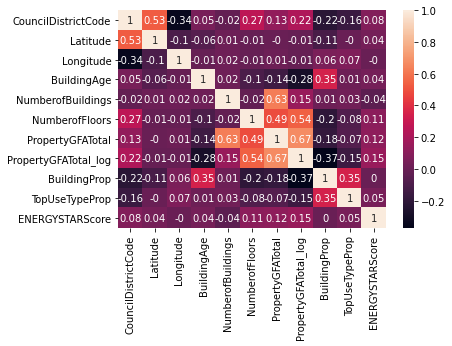

In [21]:
matrice_corr = X.corr().round(2)
sns.heatmap(data=matrice_corr, annot=True)

# B - Préprocessing <a name=B></a>
## Creation Train & Test Set :

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=5)

In [23]:
print('Nombre d\'individus dans le Train Set :',len(X_train), '\nNombre d\'individus dans le Test Set :',len(X_test),'\nNombre de features :',len(X_train.columns))

Nombre d'individus dans le Train Set : 2629 
Nombre d'individus dans le Test Set : 658 
Nombre de features : 15


## Pipelines Preprocessing :
On réalise une pipeline de preprocessing afin de préparer les données afin qu'elles présentent le bon format pour le modèle de régression :
1. On sépare les features numérique et catégorielle
2. On créer 2 pipelines, 1 pour chaque type de variables :
    - Numériques : 
        1. Un SimpleImputer qui va valoriser les données manquantes par la médiane
        2. Un StandardScaler qui va Normaliser les données
    - Catégorielles :
        1. Un SimpleImputer qui va valoriser les données manquantes par la valeur "missing"
        2. Un OneHotEncoder qui va encoder les modalités afin de les transformer en données numériques (1 et 0)
3. On englobe ces 2 pipelines dans une pipeline de préprocessing général

In [24]:
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor

In [25]:
def rmse(x,y,modele,col=''):
    if col!='':
        return (np.sqrt(mean_squared_error(y[col], modele.predict(x))))
    else:
        return (np.sqrt(mean_squared_error(y, modele.predict(x))))

Conversion du district code en variable catégorielle :

In [26]:
X['CouncilDistrictCode']=X['CouncilDistrictCode'].astype(str)

Selection des features :

In [27]:
#selection des features 
numerical_features = ['Latitude','Longitude','BuildingAge','NumberofBuildings','NumberofFloors','PropertyGFATotal','BuildingProp','TopUseTypeProp','ENERGYSTARScore']
numerical_features_log = ['Latitude','Longitude','BuildingAge','NumberofBuildings','NumberofFloors','PropertyGFATotal_log','BuildingProp','TopUseTypeProp','ENERGYSTARScore']
categorical_features = ['BuildingType','PrimaryPropertyType','CouncilDistrictCode','Neighborhood','LargestPropertyUseType']

In [28]:
#Pipeline preprocessing des colonnes en fonction de leur type
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), OneHotEncoder(handle_unknown = 'ignore'))

In [29]:
#Pipeline preprocessing complète
preprocessor=make_column_transformer((numerical_pipeline, numerical_features),(categorical_pipeline, categorical_features))
preprocessor_log=make_column_transformer((numerical_pipeline, numerical_features_log),(categorical_pipeline, categorical_features))

# C - Modélisation <a name=C></a>
Création d'un tableau qui contiendras les métriques de performances pour chaques modèles : 
- Temps : d'entraînement, d'évaluation et total
- R²
- RMSE

In [30]:
df_score = pd.DataFrame(columns=['nom_modele','target','commentaires','r2_cv','rmse_cv','r2_test','rmse_test','param_time','fit_time','score_time','time_total'])

## C.1 - Madèle Baseline : Dummy Regressor <a name=C.1></a>
Afin de vérifier que nos modèles sont performants, ils faut qu'on puisse les comparer à un modèle "bête" ou "dummy regressor" qui va effectuer des prédicitions "bête", par exemple ici il nous renverras uniquement la moyenne :

In [31]:
from sklearn.dummy import DummyRegressor

### SiteEnergyUse(kBtu)

In [32]:
dummy_reg = make_pipeline(preprocessor, DummyRegressor(strategy='mean'))
cv=cross_validate(dummy_reg, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [33]:
dummy_reg.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=dummy_reg.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,dummy_reg,col='SiteEnergyUse(kBtu)')

In [34]:
row={'nom_modele': 'Dummy',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':'mean',
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215


### Log(SiteEnergyUse(kBtu))

In [35]:
dummy_reg = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=DummyRegressor(strategy='mean'),func=np.log, inverse_func=np.exp))
cv=cross_validate(dummy_reg, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [36]:
dummy_reg.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=dummy_reg.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,dummy_reg,col='SiteEnergyUse(kBtu)')

In [37]:
row={'nom_modele': 'Dummy',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':'mean-Log(y)',
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182


### TotalGHGEmissions(MetricTonsCO2e)

In [38]:
dummy_reg = make_pipeline(preprocessor, DummyRegressor(strategy='mean'))
cv=cross_validate(dummy_reg, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [39]:
dummy_reg.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=dummy_reg.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,dummy_reg,col='TotalGHGEmissions(MetricTonsCO2e)')

In [40]:
row={'nom_modele': 'Dummy',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':'mean',
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699


### Log(TotalGHGEmissions(MetricTonsCO2e))

In [41]:
dummy_reg = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=DummyRegressor(strategy='mean'),func=np.log, inverse_func=np.exp))
cv=cross_validate(dummy_reg, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [42]:
dummy_reg.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=dummy_reg.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,dummy_reg,col='TotalGHGEmissions(MetricTonsCO2e)')

In [43]:
row={'nom_modele': 'Dummy',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':'mean-Log(y)',
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792


## C.2 - Regression Linéaire <a name=C.2></a>
### SiteEnergyUse(kBtu)

In [44]:
#Pipeline modèle
model = make_pipeline(preprocessor, LinearRegression())
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [45]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [46]:
row={'nom_modele': 'RegLin',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':'',
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365


### Log(SiteEnergyUse(kBtu))

In [47]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [48]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [49]:
row={'nom_modele': 'RegLin',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':'Log(y)',
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990


### TotalGHGEmissions(MetricTonsCO2e)

In [50]:
#Pipeline modèle
model = make_pipeline(preprocessor, LinearRegression())
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [51]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [52]:
row={'nom_modele': 'RegLin',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':'',
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267


### Log(TotalGHGEmissions(MetricTonsCO2e))

In [53]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [54]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [55]:
row={'nom_modele': 'RegLin',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':'Log(y)',
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300


On va maintenant chercher à améliorer notre modèle en pondérant nos coefficient, ou en cherchant à retirer des coefficient, en régularisant notre modèle linéaire avec une regression Ridge, Lasso puis ElasticNet.
## C.3 - Régression Ridge <a name=C.3></a>
### SiteEnergyUse(kBtu)

In [56]:
from sklearn.linear_model import Ridge

En regression de Ridge il faut que l'on ajuste un hyperparamètre : alpha. On va donc réaliser une cross-validation avec une grid-search afin de trouver l'alpha optimal :

In [57]:
#Pipeline modèle
model = make_pipeline(preprocessor, Ridge())
params ={
    'ridge__alpha' : np.arange(0, 1.1, 0.1) #on définit un tableau de valeurs pour alpha alant de 0 à 1 avec un pas de 0.1
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
alpha_opti=grid.best_params_['ridge__alpha']
alpha_opti

1.0

In [58]:
grid.best_score_

0.5720358017743805

In [59]:
model = make_pipeline(preprocessor, Ridge(alpha=alpha_opti))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [60]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [61]:
row={'nom_modele': 'Ridge',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('alpha',alpha_opti),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300
8,Ridge,SiteEnergyUse(kBtu),"(alpha, 1.0)",0.572036,1.410388e+07,0.711218,1.271246e+07,1.537944,0.094723,0.029480,0.124203


### Log(SiteEnergyUse(kBtu))

In [62]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=Ridge(),func=np.log, inverse_func=np.exp))
params ={
    'transformedtargetregressor__regressor__alpha' : np.arange(0, 1.1, 0.1) #on définit un tableau de valeurs pour alpha alant de 0 à 1 avec un pas de 0.1
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
alpha_opti=grid.best_params_['transformedtargetregressor__regressor__alpha']
alpha_opti

0.8

In [63]:
grid.best_score_

0.6245918212131871

In [64]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=Ridge(alpha=alpha_opti),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [65]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [66]:
row={'nom_modele': 'Ridge',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('alpha',alpha_opti,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300
8,Ridge,SiteEnergyUse(kBtu),"(alpha, 1.0)",0.572036,1.410388e+07,0.711218,1.271246e+07,1.537944,0.094723,0.029480,0.124203
9,Ridge,SiteEnergyUse(kBtu),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352


### TotalGHGEmissions(MetricTonsCO2e)

In [67]:
#Pipeline modèle
model = make_pipeline(preprocessor, Ridge())
params ={
    'ridge__alpha' : np.arange(0, 1.1, 0.1)
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
alpha_opti=grid.best_params_['ridge__alpha']
alpha_opti

1.0

In [68]:
grid.best_score_

0.3741010739889018

In [69]:
model = make_pipeline(preprocessor, Ridge(alpha=alpha_opti))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [70]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [71]:
row={'nom_modele': 'Ridge',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('alpha',alpha_opti),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300
8,Ridge,SiteEnergyUse(kBtu),"(alpha, 1.0)",0.572036,1.410388e+07,0.711218,1.271246e+07,1.537944,0.094723,0.029480,0.124203
9,Ridge,SiteEnergyUse(kBtu),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352


### Log(TotalGHGEmissions(MetricTonsCO2e))

In [72]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=Ridge(),func=np.log, inverse_func=np.exp))
params ={
    'transformedtargetregressor__regressor__alpha' : np.arange(0, 1.1, 0.1) #on définit un tableau de valeurs pour alpha alant de 0 à 1 avec un pas de 0.1
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
alpha_opti=grid.best_params_['transformedtargetregressor__regressor__alpha']
alpha_opti

1.0

In [73]:
grid.best_score_

0.5117932084364033

In [74]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=Ridge(alpha=alpha_opti),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [75]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [76]:
row={'nom_modele': 'Ridge',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('alpha',alpha_opti,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300
8,Ridge,SiteEnergyUse(kBtu),"(alpha, 1.0)",0.572036,1.410388e+07,0.711218,1.271246e+07,1.537944,0.094723,0.029480,0.124203
9,Ridge,SiteEnergyUse(kBtu),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352


## C.4 - Régression Lasso <a name=C.4></a>
### SiteEnergyUse(kBtu)

In [77]:
from sklearn.linear_model import Lasso

In [78]:
#Pipeline modèle
model = make_pipeline(preprocessor, Lasso())
params ={
    'lasso__alpha' : np.arange(25820, 25850, 1)
}

In [79]:
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
alpha_opti=grid.best_params_['lasso__alpha']
alpha_opti

25849

In [80]:
grid.best_score_

0.5808922366017171

In [81]:
model = make_pipeline(preprocessor, Lasso(alpha=alpha_opti))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [82]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [83]:
row={'nom_modele': 'Lasso',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('alpha',alpha_opti),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300
8,Ridge,SiteEnergyUse(kBtu),"(alpha, 1.0)",0.572036,1.410388e+07,0.711218,1.271246e+07,1.537944,0.094723,0.029480,0.124203
9,Ridge,SiteEnergyUse(kBtu),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352


### Log(SiteEnergyUse(kBtu))

In [84]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=Lasso(),func=np.log, inverse_func=np.exp))
params ={
    'transformedtargetregressor__regressor__alpha' : np.arange(0.01, 0.5, 0.01)
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
alpha_opti=grid.best_params_['transformedtargetregressor__regressor__alpha']
alpha_opti

0.03

In [85]:
grid.best_score_

0.6087079184676908

In [86]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=Lasso(alpha=alpha_opti),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [87]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [88]:
row={'nom_modele': 'Lasso',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('alpha',alpha_opti,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300
8,Ridge,SiteEnergyUse(kBtu),"(alpha, 1.0)",0.572036,1.410388e+07,0.711218,1.271246e+07,1.537944,0.094723,0.029480,0.124203
9,Ridge,SiteEnergyUse(kBtu),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352


### TotalGHGEmissions(MetricTonsCO2e)

In [89]:
#Pipeline modèle
model = make_pipeline(preprocessor, Lasso())
params ={
    'lasso__alpha' : np.arange(0.1, 1, 0.1)
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
alpha_opti=grid.best_params_['lasso__alpha']
alpha_opti

0.9

In [90]:
grid.best_score_

0.3971798469508184

In [91]:
model = make_pipeline(preprocessor, Lasso(alpha=alpha_opti))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [92]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [93]:
row={'nom_modele': 'Lasso',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('alpha', np.around(alpha_opti,2)),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300
8,Ridge,SiteEnergyUse(kBtu),"(alpha, 1.0)",0.572036,1.410388e+07,0.711218,1.271246e+07,1.537944,0.094723,0.029480,0.124203
9,Ridge,SiteEnergyUse(kBtu),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352


### Log(TotalGHGEmissions(MetricTonsCO2e))

In [94]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=Lasso(),func=np.log, inverse_func=np.exp))
params ={
    'transformedtargetregressor__regressor__alpha' : np.arange(0.01, 0.5, 0.01)
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
alpha_opti=grid.best_params_['transformedtargetregressor__regressor__alpha']
alpha_opti

0.05

In [95]:
grid.best_score_

0.2675170891232841

In [96]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=Lasso(alpha=alpha_opti),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [97]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [98]:
row={'nom_modele': 'Lasso',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('alpha',alpha_opti,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300
8,Ridge,SiteEnergyUse(kBtu),"(alpha, 1.0)",0.572036,1.410388e+07,0.711218,1.271246e+07,1.537944,0.094723,0.029480,0.124203
9,Ridge,SiteEnergyUse(kBtu),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352


## C.5 - ElasticNet <a name=C.5></a>
### SiteEnergyUse(kBtu)

In [99]:
from sklearn.linear_model import ElasticNet

In [100]:
#Pipeline modèle
model = make_pipeline(preprocessor, ElasticNet())
params ={
    'elasticnet__alpha' : [0.1, 1.0, 10, 100, 1000],
    'elasticnet__l1_ratio' : [.1, .5, .7, .9, .95, .99]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
grid.best_params_
alpha_opti = grid.best_params_['elasticnet__alpha']
l1_opti= grid.best_params_['elasticnet__l1_ratio']
alpha_opti, l1_opti

(0.1, 0.95)

In [101]:
grid.best_score_

0.589743183387221

In [102]:
model = make_pipeline(preprocessor, ElasticNet(alpha=alpha_opti,l1_ratio=l1_opti))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [103]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [104]:
row={'nom_modele': 'ElasticNet',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('alpha',alpha_opti,'- l1',l1_opti),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300
8,Ridge,SiteEnergyUse(kBtu),"(alpha, 1.0)",0.572036,1.410388e+07,0.711218,1.271246e+07,1.537944,0.094723,0.029480,0.124203
9,Ridge,SiteEnergyUse(kBtu),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352


### Log(SiteEnergyUse(kBtu))

In [105]:
#Pipeline modèle
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=ElasticNet(),func=np.log, inverse_func=np.exp))
params ={
    'transformedtargetregressor__regressor__alpha' : [0.1, 1.0, 10, 100, 1000],
    'transformedtargetregressor__regressor__l1_ratio' : [.1, .5, .7, .9, .95, .99]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
alpha_opti=grid.best_params_['transformedtargetregressor__regressor__alpha']
l1_opti=grid.best_params_['transformedtargetregressor__regressor__l1_ratio']
alpha_opti, l1_opti

(0.1, 0.5)

In [106]:
grid.best_score_

0.4977767951469206

In [107]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=ElasticNet(alpha=alpha_opti,l1_ratio=l1_opti),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [108]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [109]:
row={'nom_modele': 'ElasticNet',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('alpha',alpha_opti,'- l1',l1_opti,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
0,Dummy,SiteEnergyUse(kBtu),mean,-0.005799,2.324259e+07,-0.000125,2.365766e+07,NaN,0.073313,0.034902,0.108215
1,Dummy,SiteEnergyUse(kBtu),mean-Log(y),-0.063034,2.377979e+07,-0.051329,2.425570e+07,NaN,0.087277,0.034905,0.122182
2,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean,-0.010259,6.168327e+02,-0.000698,7.355771e+02,NaN,0.078788,0.032911,0.111699
3,Dummy,TotalGHGEmissions(MetricTonsCO2e),mean-Log(y),-0.051433,6.281297e+02,-0.037648,7.490343e+02,NaN,0.063890,0.026902,0.090792
4,RegLin,SiteEnergyUse(kBtu),,0.560859,1.425792e+07,0.728881,1.231756e+07,NaN,0.213425,0.028939,0.242365
5,RegLin,SiteEnergyUse(kBtu),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
6,RegLin,TotalGHGEmissions(MetricTonsCO2e),,0.365145,4.458108e+02,0.670752,4.219282e+02,NaN,0.246341,0.034926,0.281267
7,RegLin,TotalGHGEmissions(MetricTonsCO2e),Log(y),0.481522,4.233367e+02,0.840200,2.939439e+02,NaN,0.246364,0.034936,0.281300
8,Ridge,SiteEnergyUse(kBtu),"(alpha, 1.0)",0.572036,1.410388e+07,0.711218,1.271246e+07,1.537944,0.094723,0.029480,0.124203
9,Ridge,SiteEnergyUse(kBtu),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352


### TotalGHGEmissions(MetricTonsCO2e)

In [110]:
#Pipeline modèle
model = make_pipeline(preprocessor, ElasticNet())
params ={
    'elasticnet__alpha' : [0.1, 1.0, 10, 100, 1000],
    'elasticnet__l1_ratio' : [.1, .5, .7, .9, .95, .99]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
alpha_opti=grid.best_params_['elasticnet__alpha']
l1_opti=grid.best_params_['elasticnet__l1_ratio']
alpha_opti, l1_opti

(0.1, 0.95)

In [111]:
grid.best_score_

0.3961327972253913

In [112]:
model = make_pipeline(preprocessor, ElasticNet(alpha=alpha_opti,l1_ratio=l1_opti))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [113]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [114]:
row={'nom_modele': 'ElasticNet',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('alpha',alpha_opti,'l1',l1_opti),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
14,Lasso,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.9)",0.397180,4.399477e+02,0.656716,4.308278e+02,3.064208,0.220402,0.030934,0.251336
15,Lasso,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.05, Log(y))",0.267517,5.276179e+02,0.238858,6.415189e+02,7.341063,0.103215,0.031914,0.135128
16,ElasticNet,SiteEnergyUse(kBtu),"(alpha, 0.1, - l1, 0.95)",0.589743,1.376844e+07,0.623808,1.450940e+07,8.108862,0.621866,0.031057,0.652923
17,ElasticNet,SiteEnergyUse(kBtu),"(alpha, 0.1, - l1, 0.5, Log(y))",0.497777,1.639639e+07,0.376420,1.868059e+07,4.413077,0.095691,0.030831,0.126523
18,ElasticNet,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.1, l1, 0.95)",0.396133,4.547571e+02,0.617331,4.548708e+02,4.775232,0.255288,0.030040,0.285328


### Log(TotalGHGEmissions(MetricTonsCO2e))

In [115]:
#Pipeline modèle
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=ElasticNet(),func=np.log, inverse_func=np.exp))
params ={
    'transformedtargetregressor__regressor__alpha' : [0.1, 1.0, 10, 100, 1000],
    'transformedtargetregressor__regressor__l1_ratio' : [.1, .5, .7, .9, .95, .99]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
alpha_opti=grid.best_params_['transformedtargetregressor__regressor__alpha']
l1_opti=grid.best_params_['transformedtargetregressor__regressor__l1_ratio']
alpha_opti, l1_opti

(0.1, 0.7)

In [116]:
grid.best_score_

0.22407804355609856

In [117]:
model = make_pipeline(preprocessor_log, TransformedTargetRegressor(regressor=ElasticNet(alpha=alpha_opti,l1_ratio=l1_opti),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [118]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [119]:
row={'nom_modele': 'ElasticNet',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('alpha',alpha_opti,'l1',l1_opti,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
15,Lasso,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.05, Log(y))",0.267517,5.276179e+02,0.238858,6.415189e+02,7.341063,0.103215,0.031914,0.135128
16,ElasticNet,SiteEnergyUse(kBtu),"(alpha, 0.1, - l1, 0.95)",0.589743,1.376844e+07,0.623808,1.450940e+07,8.108862,0.621866,0.031057,0.652923
17,ElasticNet,SiteEnergyUse(kBtu),"(alpha, 0.1, - l1, 0.5, Log(y))",0.497777,1.639639e+07,0.376420,1.868059e+07,4.413077,0.095691,0.030831,0.126523
18,ElasticNet,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.1, l1, 0.95)",0.396133,4.547571e+02,0.617331,4.548708e+02,4.775232,0.255288,0.030040,0.285328
19,ElasticNet,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.1, l1, 0.7, Log(y))",0.224078,5.397447e+02,0.164915,6.719578e+02,4.419567,0.091721,0.031916,0.123637


# D - Méthodes Ensemblistes <a name=D></a>
## D.1 - Bagging <a name=D.1></a>

In [120]:
from sklearn.ensemble import BaggingRegressor

### SiteEnergyUse(kBtu)

In [121]:
model = make_pipeline(preprocessor,BaggingRegressor(random_state=5))
params = {
    'baggingregressor__n_estimators' : [10,20,30,40,50]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
n_estim_opti=grid.best_params_['baggingregressor__n_estimators']
n_estim_opti

30

In [122]:
grid.best_score_

0.6217506173415689

In [123]:
model = make_pipeline(preprocessor,BaggingRegressor(n_estimators=n_estim_opti, random_state=5))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [124]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [125]:
row={'nom_modele': 'Bagging',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('n_estimators:',n_estim_opti),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
16,ElasticNet,SiteEnergyUse(kBtu),"(alpha, 0.1, - l1, 0.95)",0.589743,1.376844e+07,0.623808,1.450940e+07,8.108862,0.621866,0.031057,0.652923
17,ElasticNet,SiteEnergyUse(kBtu),"(alpha, 0.1, - l1, 0.5, Log(y))",0.497777,1.639639e+07,0.376420,1.868059e+07,4.413077,0.095691,0.030831,0.126523
18,ElasticNet,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.1, l1, 0.95)",0.396133,4.547571e+02,0.617331,4.548708e+02,4.775232,0.255288,0.030040,0.285328
19,ElasticNet,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.1, l1, 0.7, Log(y))",0.224078,5.397447e+02,0.164915,6.719578e+02,4.419567,0.091721,0.031916,0.123637
20,Bagging,SiteEnergyUse(kBtu),"(n_estimators:, 30)",0.621751,1.506088e+07,0.895782,7.636865e+06,37.054937,6.963839,0.071813,7.035653


### Log(SiteEnergyUse(kBtu))

In [126]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(regressor=BaggingRegressor(random_state=5),func=np.log, inverse_func=np.exp))
params = {
    'transformedtargetregressor__regressor__n_estimators' : [10,20,30,40,50]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
n_estim_opti=grid.best_params_['transformedtargetregressor__regressor__n_estimators']
n_estim_opti

40

In [127]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(regressor=BaggingRegressor(n_estimators=n_estim_opti, random_state=5),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [128]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [129]:
row={'nom_modele': 'Bagging',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('n_estimators:',n_estim_opti,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
17,ElasticNet,SiteEnergyUse(kBtu),"(alpha, 0.1, - l1, 0.5, Log(y))",0.497777,1.639639e+07,0.376420,1.868059e+07,4.413077,0.095691,0.030831,0.126523
18,ElasticNet,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.1, l1, 0.95)",0.396133,4.547571e+02,0.617331,4.548708e+02,4.775232,0.255288,0.030040,0.285328
19,ElasticNet,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.1, l1, 0.7, Log(y))",0.224078,5.397447e+02,0.164915,6.719578e+02,4.419567,0.091721,0.031916,0.123637
20,Bagging,SiteEnergyUse(kBtu),"(n_estimators:, 30)",0.621751,1.506088e+07,0.895782,7.636865e+06,37.054937,6.963839,0.071813,7.035653
21,Bagging,SiteEnergyUse(kBtu),"(n_estimators:, 40, Log(y))",0.599755,1.561747e+07,0.742291,1.200906e+07,36.651052,8.731171,0.089797,8.820968


### TotalGHGEmissions(MetricTonsCO2e)

In [130]:
model = make_pipeline(preprocessor,BaggingRegressor(random_state=5))
params = {
    'baggingregressor__n_estimators' : [10,20,30,40,50]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
n_estim_opti=grid.best_params_['baggingregressor__n_estimators']
n_estim_opti

40

In [131]:
model = make_pipeline(preprocessor,BaggingRegressor(n_estimators=n_estim_opti,random_state=5))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [132]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [133]:
row={'nom_modele': 'Bagging',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('n_estimators:',n_estim_opti),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
18,ElasticNet,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.1, l1, 0.95)",0.396133,4.547571e+02,0.617331,4.548708e+02,4.775232,0.255288,0.030040,0.285328
19,ElasticNet,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.1, l1, 0.7, Log(y))",0.224078,5.397447e+02,0.164915,6.719578e+02,4.419567,0.091721,0.031916,0.123637
20,Bagging,SiteEnergyUse(kBtu),"(n_estimators:, 30)",0.621751,1.506088e+07,0.895782,7.636865e+06,37.054937,6.963839,0.071813,7.035653
21,Bagging,SiteEnergyUse(kBtu),"(n_estimators:, 40, Log(y))",0.599755,1.561747e+07,0.742291,1.200906e+07,36.651052,8.731171,0.089797,8.820968
22,Bagging,TotalGHGEmissions(MetricTonsCO2e),"(n_estimators:, 40)",0.581370,4.038613e+02,0.927506,1.979828e+02,38.122316,9.515751,0.087791,9.603542


### Log(TotalGHGEmissions(MetricTonsCO2e))

In [134]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(regressor=BaggingRegressor(random_state=5),func=np.log, inverse_func=np.exp))
params = {
    'transformedtargetregressor__regressor__n_estimators' : [10,20,30,40,50]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
n_estim_opti=grid.best_params_['transformedtargetregressor__regressor__n_estimators']
n_estim_opti

40

In [135]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(regressor=BaggingRegressor(n_estimators=n_estim_opti,random_state=5),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [136]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [137]:
row={'nom_modele': 'Bagging',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('n_estimators:',n_estim_opti,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
19,ElasticNet,TotalGHGEmissions(MetricTonsCO2e),"(alpha, 0.1, l1, 0.7, Log(y))",0.224078,5.397447e+02,0.164915,6.719578e+02,4.419567,0.091721,0.031916,0.123637
20,Bagging,SiteEnergyUse(kBtu),"(n_estimators:, 30)",0.621751,1.506088e+07,0.895782,7.636865e+06,37.054937,6.963839,0.071813,7.035653
21,Bagging,SiteEnergyUse(kBtu),"(n_estimators:, 40, Log(y))",0.599755,1.561747e+07,0.742291,1.200906e+07,36.651052,8.731171,0.089797,8.820968
22,Bagging,TotalGHGEmissions(MetricTonsCO2e),"(n_estimators:, 40)",0.581370,4.038613e+02,0.927506,1.979828e+02,38.122316,9.515751,0.087791,9.603542
23,Bagging,TotalGHGEmissions(MetricTonsCO2e),"(n_estimators:, 40, Log(y))",0.515605,4.430565e+02,0.817461,3.141622e+02,34.839508,8.442006,0.096972,8.538978


## D.2 - RandomForest <a name=D.2></a>

In [138]:
from sklearn.ensemble import RandomForestRegressor

### SiteEnergyUse(kBtu)

In [139]:
model = make_pipeline(preprocessor,RandomForestRegressor(oob_score=True, random_state=5))
params = {
    'randomforestregressor__n_estimators' : [100,150,200],
    'randomforestregressor__max_depth' : [None,1,2],
    'randomforestregressor__min_impurity_decrease' : [0.0,0.01,0.1]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
grid.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__n_estimators': 200}

In [140]:
n_estim = grid.best_params_['randomforestregressor__n_estimators']
depth_opti = grid.best_params_['randomforestregressor__max_depth']
impurity_dec = grid.best_params_['randomforestregressor__min_impurity_decrease']

In [141]:
grid.best_score_

0.6294002841184071

In [142]:
model = make_pipeline(preprocessor,RandomForestRegressor(n_estimators=n_estim,max_depth=depth_opti,
                                                         min_impurity_decrease=impurity_dec,oob_score=True, random_state=5))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [143]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [144]:
row={'nom_modele': 'RandomForest',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('n_estim',n_estim,'- max_depth',depth_opti,'- min_impurity_dec',impurity_dec),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
20,Bagging,SiteEnergyUse(kBtu),"(n_estimators:, 30)",0.621751,1.506088e+07,0.895782,7.636865e+06,37.054937,6.963839,0.071813,7.035653
21,Bagging,SiteEnergyUse(kBtu),"(n_estimators:, 40, Log(y))",0.599755,1.561747e+07,0.742291,1.200906e+07,36.651052,8.731171,0.089797,8.820968
22,Bagging,TotalGHGEmissions(MetricTonsCO2e),"(n_estimators:, 40)",0.581370,4.038613e+02,0.927506,1.979828e+02,38.122316,9.515751,0.087791,9.603542
23,Bagging,TotalGHGEmissions(MetricTonsCO2e),"(n_estimators:, 40, Log(y))",0.515605,4.430565e+02,0.817461,3.141622e+02,34.839508,8.442006,0.096972,8.538978
24,RandomForest,SiteEnergyUse(kBtu),"(n_estim, 200, - max_depth, None, - min_impuri...",0.629400,1.485904e+07,0.894802,7.672713e+06,358.246142,45.978173,0.172601,46.150774


### Log(SiteEnergyUse(kBtu))

In [145]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(regressor=RandomForestRegressor(oob_score=True, random_state=5),
                                                              func=np.log, inverse_func=np.exp))
params = {
    'transformedtargetregressor__regressor__n_estimators' : [100,150,200],
    'transformedtargetregressor__regressor__max_depth' : [None,1,2],
    'transformedtargetregressor__regressor__min_impurity_decrease' : [0.0,0.01,0.1]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
grid.best_params_

{'transformedtargetregressor__regressor__max_depth': None,
 'transformedtargetregressor__regressor__min_impurity_decrease': 0.0,
 'transformedtargetregressor__regressor__n_estimators': 200}

In [146]:
grid.best_score_

0.5992085286878728

In [147]:
n_estim = grid.best_params_['transformedtargetregressor__regressor__n_estimators']
depth_opti = grid.best_params_['transformedtargetregressor__regressor__max_depth']
impurity_dec = grid.best_params_['transformedtargetregressor__regressor__min_impurity_decrease']

In [148]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(regressor=RandomForestRegressor(
    n_estimators=n_estim,max_depth=depth_opti,min_impurity_decrease=impurity_dec,oob_score=True, random_state=5),
                                                                  func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [149]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [150]:
row={'nom_modele': 'RandomForest',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('n_estim',n_estim,'- max_depth',depth_opti,'- min_impurity_dec',impurity_dec,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
21,Bagging,SiteEnergyUse(kBtu),"(n_estimators:, 40, Log(y))",0.599755,1.561747e+07,0.742291,1.200906e+07,36.651052,8.731171,0.089797,8.820968
22,Bagging,TotalGHGEmissions(MetricTonsCO2e),"(n_estimators:, 40)",0.581370,4.038613e+02,0.927506,1.979828e+02,38.122316,9.515751,0.087791,9.603542
23,Bagging,TotalGHGEmissions(MetricTonsCO2e),"(n_estimators:, 40, Log(y))",0.515605,4.430565e+02,0.817461,3.141622e+02,34.839508,8.442006,0.096972,8.538978
24,RandomForest,SiteEnergyUse(kBtu),"(n_estim, 200, - max_depth, None, - min_impuri...",0.629400,1.485904e+07,0.894802,7.672713e+06,358.246142,45.978173,0.172601,46.150774
25,RandomForest,SiteEnergyUse(kBtu),"(n_estim, 200, - max_depth, None, - min_impuri...",0.599209,1.562721e+07,0.731347,1.226142e+07,171.414748,43.065769,0.160589,43.226358


### TotalGHGEmissions(MetricTonsCO2e)

In [151]:
model = make_pipeline(preprocessor,RandomForestRegressor(oob_score=True, random_state=5))
params = {
    'randomforestregressor__n_estimators' : [100,150,200],
    'randomforestregressor__max_depth' : [None,1,2],
    'randomforestregressor__min_impurity_decrease' : [0.0,0.01,0.1]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
grid.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__min_impurity_decrease': 0.1,
 'randomforestregressor__n_estimators': 200}

In [152]:
grid.best_score_

0.5770849722671513

In [153]:
n_estim = grid.best_params_['randomforestregressor__n_estimators']
depth_opti = grid.best_params_['randomforestregressor__max_depth']
impurity_dec = grid.best_params_['randomforestregressor__min_impurity_decrease']

In [154]:
model = make_pipeline(preprocessor,RandomForestRegressor(n_estimators=n_estim,max_depth=depth_opti,
                                                         min_impurity_decrease=impurity_dec,oob_score=True, random_state=5))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [155]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [156]:
row={'nom_modele': 'RandomForest',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('n_estim',n_estim,'- max_depth',depth_opti,'- min_impurity_dec',impurity_dec),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
22,Bagging,TotalGHGEmissions(MetricTonsCO2e),"(n_estimators:, 40)",0.581370,4.038613e+02,0.927506,1.979828e+02,38.122316,9.515751,0.087791,9.603542
23,Bagging,TotalGHGEmissions(MetricTonsCO2e),"(n_estimators:, 40, Log(y))",0.515605,4.430565e+02,0.817461,3.141622e+02,34.839508,8.442006,0.096972,8.538978
24,RandomForest,SiteEnergyUse(kBtu),"(n_estim, 200, - max_depth, None, - min_impuri...",0.629400,1.485904e+07,0.894802,7.672713e+06,358.246142,45.978173,0.172601,46.150774
25,RandomForest,SiteEnergyUse(kBtu),"(n_estim, 200, - max_depth, None, - min_impuri...",0.599209,1.562721e+07,0.731347,1.226142e+07,171.414748,43.065769,0.160589,43.226358
26,RandomForest,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 200, - max_depth, None, - min_impuri...",0.577085,4.052957e+02,0.906621,2.246994e+02,347.796508,42.396591,0.158181,42.554772


### Log(TotalGHGEmissions(MetricTonsCO2e))

In [157]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(
    regressor=RandomForestRegressor(oob_score=True, random_state=5),func=np.log, inverse_func=np.exp))
params = {
    'transformedtargetregressor__regressor__n_estimators' : [100,150,200],
    'transformedtargetregressor__regressor__max_depth' : [None,1,2],
    'transformedtargetregressor__regressor__min_impurity_decrease' : [0.0,0.01,0.1]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
grid.best_params_

{'transformedtargetregressor__regressor__max_depth': None,
 'transformedtargetregressor__regressor__min_impurity_decrease': 0.0,
 'transformedtargetregressor__regressor__n_estimators': 200}

In [158]:
grid.best_score_

0.5169215281991223

In [159]:
n_estim = grid.best_params_['transformedtargetregressor__regressor__n_estimators']
depth_opti = grid.best_params_['transformedtargetregressor__regressor__max_depth']
impurity_dec = grid.best_params_['transformedtargetregressor__regressor__min_impurity_decrease']

In [160]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(regressor=RandomForestRegressor(
    n_estimators=n_estim,max_depth=depth_opti,min_impurity_decrease=impurity_dec,oob_score=True, random_state=5),
                                                                  func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [161]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [162]:
row={'nom_modele': 'RandomForest',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('n_estim',n_estim,'- max_depth',depth_opti,'- min_impurity_dec',impurity_dec,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
23,Bagging,TotalGHGEmissions(MetricTonsCO2e),"(n_estimators:, 40, Log(y))",0.515605,4.430565e+02,0.817461,3.141622e+02,34.839508,8.442006,0.096972,8.538978
24,RandomForest,SiteEnergyUse(kBtu),"(n_estim, 200, - max_depth, None, - min_impuri...",0.629400,1.485904e+07,0.894802,7.672713e+06,358.246142,45.978173,0.172601,46.150774
25,RandomForest,SiteEnergyUse(kBtu),"(n_estim, 200, - max_depth, None, - min_impuri...",0.599209,1.562721e+07,0.731347,1.226142e+07,171.414748,43.065769,0.160589,43.226358
26,RandomForest,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 200, - max_depth, None, - min_impuri...",0.577085,4.052957e+02,0.906621,2.246994e+02,347.796508,42.396591,0.158181,42.554772
27,RandomForest,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 200, - max_depth, None, - min_impuri...",0.516922,4.428240e+02,0.807603,3.225343e+02,174.678661,41.973437,0.157624,42.131062


## D.3 - Gradient Boosting <a name=D.3></a>

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

### SiteEnergyUse(kBtu)

In [164]:
model = make_pipeline(preprocessor,GradientBoostingRegressor(random_state=5))
params = {
    'gradientboostingregressor__n_estimators' : [100,500,1000,2000],
    'gradientboostingregressor__max_depth' : [1,2,3],
    'gradientboostingregressor__min_impurity_decrease' : [0.0,0.01,0.1],
    'gradientboostingregressor__learning_rate' : [0.1,0.25,0.5],
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
grid.best_params_

{'gradientboostingregressor__learning_rate': 0.25,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__min_impurity_decrease': 0.0,
 'gradientboostingregressor__n_estimators': 2000}

In [165]:
grid.best_score_

0.6343308838028158

In [166]:
n_estim = grid.best_params_['gradientboostingregressor__n_estimators']
depth_opti = grid.best_params_['gradientboostingregressor__max_depth']
impurity_dec = grid.best_params_['gradientboostingregressor__min_impurity_decrease']
learning_rate = grid.best_params_['gradientboostingregressor__learning_rate']

In [167]:
model = make_pipeline(preprocessor,GradientBoostingRegressor(
    n_estimators=n_estim,max_depth=depth_opti,min_impurity_decrease=impurity_dec,learning_rate=learning_rate,random_state=5))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [168]:
cv['test_r2'].mean()

0.6343308838028158

In [169]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [170]:
row={'nom_modele': 'Gradient Boosting',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('n_estim',n_estim,'- max_depth',depth_opti,'- min_impurity_dec',impurity_dec,'- learning_rate',learning_rate),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
24,RandomForest,SiteEnergyUse(kBtu),"(n_estim, 200, - max_depth, None, - min_impuri...",0.629400,1.485904e+07,0.894802,7.672713e+06,358.246142,45.978173,0.172601,46.150774
25,RandomForest,SiteEnergyUse(kBtu),"(n_estim, 200, - max_depth, None, - min_impuri...",0.599209,1.562721e+07,0.731347,1.226142e+07,171.414748,43.065769,0.160589,43.226358
26,RandomForest,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 200, - max_depth, None, - min_impuri...",0.577085,4.052957e+02,0.906621,2.246994e+02,347.796508,42.396591,0.158181,42.554772
27,RandomForest,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 200, - max_depth, None, - min_impuri...",0.516922,4.428240e+02,0.807603,3.225343e+02,174.678661,41.973437,0.157624,42.131062
28,Gradient Boosting,SiteEnergyUse(kBtu),"(n_estim, 2000, - max_depth, 3, - min_impurity...",0.634331,1.482951e+07,0.929548,6.279025e+06,1104.165163,33.723779,0.160626,33.884405


### Log(SiteEnergyUse(kBtu))

In [171]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(regressor=GradientBoostingRegressor(random_state=5),
                                                              func=np.log, inverse_func=np.exp))
params = {
    'transformedtargetregressor__regressor__n_estimators' : [100,500,1000,2000],
    'transformedtargetregressor__regressor__max_depth' : [1,2,3],
    'transformedtargetregressor__regressor__min_impurity_decrease' : [0.0,0.01,0.1],
    'transformedtargetregressor__regressor__learning_rate' : [0.1,0.25,0.5]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
param_end = time.time()
grid.best_params_

{'transformedtargetregressor__regressor__learning_rate': 0.5,
 'transformedtargetregressor__regressor__max_depth': 3,
 'transformedtargetregressor__regressor__min_impurity_decrease': 0.0,
 'transformedtargetregressor__regressor__n_estimators': 1000}

In [172]:
grid.best_score_

0.7855716772244946

In [173]:
n_estim = grid.best_params_['transformedtargetregressor__regressor__n_estimators']
depth_opti = grid.best_params_['transformedtargetregressor__regressor__max_depth']
impurity_dec = grid.best_params_['transformedtargetregressor__regressor__min_impurity_decrease']
learning_rate = grid.best_params_['transformedtargetregressor__regressor__learning_rate']

In [174]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(
    regressor=GradientBoostingRegressor(n_estimators=n_estim,max_depth=depth_opti,min_impurity_decrease=impurity_dec,
                                        learning_rate=learning_rate,random_state=5),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['SiteEnergyUse(kBtu)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [175]:
cv['test_r2'].mean()

0.7855716772244946

In [176]:
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
r2_test=model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
rmse_test=rmse(X_test,y_test,model,col='SiteEnergyUse(kBtu)')

In [177]:
row={'nom_modele': 'Gradient Boosting',
     'target': 'SiteEnergyUse(kBtu)',
     'commentaires':('n_estim',n_estim,'- max_depth',depth_opti,'- min_impurity_dec',impurity_dec,'- learning_rate',learning_rate,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
25,RandomForest,SiteEnergyUse(kBtu),"(n_estim, 200, - max_depth, None, - min_impuri...",0.599209,1.562721e+07,0.731347,1.226142e+07,171.414748,43.065769,0.160589,43.226358
26,RandomForest,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 200, - max_depth, None, - min_impuri...",0.577085,4.052957e+02,0.906621,2.246994e+02,347.796508,42.396591,0.158181,42.554772
27,RandomForest,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 200, - max_depth, None, - min_impuri...",0.516922,4.428240e+02,0.807603,3.225343e+02,174.678661,41.973437,0.157624,42.131062
28,Gradient Boosting,SiteEnergyUse(kBtu),"(n_estim, 2000, - max_depth, 3, - min_impurity...",0.634331,1.482951e+07,0.929548,6.279025e+06,1104.165163,33.723779,0.160626,33.884405
29,Gradient Boosting,SiteEnergyUse(kBtu),"(n_estim, 1000, - max_depth, 3, - min_impurity...",0.785572,1.116561e+07,0.813886,1.020550e+07,941.227381,16.463487,0.095717,16.559204


### TotalGHGEmissions(MetricTonsCO2e)

In [178]:
model = make_pipeline(preprocessor,GradientBoostingRegressor(random_state=5))
params = {
    'gradientboostingregressor__n_estimators' : [100,500,1000,2000],
    'gradientboostingregressor__max_depth' : [1,2,3],
    'gradientboostingregressor__min_impurity_decrease' : [0.0,0.01,0.1],
    'gradientboostingregressor__learning_rate' : [0.1,0.25,0.5],
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
grid.best_params_

{'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__min_impurity_decrease': 0.0,
 'gradientboostingregressor__n_estimators': 2000}

In [179]:
grid.best_score_

0.5758106593666064

In [180]:
n_estim = grid.best_params_['gradientboostingregressor__n_estimators']
depth_opti = grid.best_params_['gradientboostingregressor__max_depth']
impurity_dec = grid.best_params_['gradientboostingregressor__min_impurity_decrease']
learning_rate = grid.best_params_['gradientboostingregressor__learning_rate']

In [181]:
model = make_pipeline(preprocessor,GradientBoostingRegressor(
    n_estimators=n_estim,max_depth=depth_opti,min_impurity_decrease=impurity_dec,learning_rate=learning_rate,random_state=5))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [182]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [183]:
row={'nom_modele': 'Gradient Boosting',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('n_estim',n_estim,'- max_depth',depth_opti,'- min_impurity_dec',impurity_dec,'- learning_rate',learning_rate),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
26,RandomForest,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 200, - max_depth, None, - min_impuri...",0.577085,4.052957e+02,0.906621,2.246994e+02,347.796508,42.396591,0.158181,42.554772
27,RandomForest,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 200, - max_depth, None, - min_impuri...",0.516922,4.428240e+02,0.807603,3.225343e+02,174.678661,41.973437,0.157624,42.131062
28,Gradient Boosting,SiteEnergyUse(kBtu),"(n_estim, 2000, - max_depth, 3, - min_impurity...",0.634331,1.482951e+07,0.929548,6.279025e+06,1104.165163,33.723779,0.160626,33.884405
29,Gradient Boosting,SiteEnergyUse(kBtu),"(n_estim, 1000, - max_depth, 3, - min_impurity...",0.785572,1.116561e+07,0.813886,1.020550e+07,941.227381,16.463487,0.095717,16.559204
30,Gradient Boosting,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 2000, - max_depth, 3, - min_impurity...",0.575811,4.102282e+02,0.952193,1.607758e+02,1115.399942,32.119838,0.208353,32.328191


### Log(TotalGHGEmissions(MetricTonsCO2e))

In [184]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(regressor=GradientBoostingRegressor(random_state=5),
                                                              func=np.log, inverse_func=np.exp))
params = {
    'transformedtargetregressor__regressor__n_estimators' : [100,500,1000,2000],
    'transformedtargetregressor__regressor__max_depth' : [1,2,3],
    'transformedtargetregressor__regressor__min_impurity_decrease' : [0.0,0.01,0.1],
    'transformedtargetregressor__regressor__learning_rate' : [0.1,0.25,0.5]
}
param_start = time.time()
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train,y_train['TotalGHGEmissions(MetricTonsCO2e)'])
param_end = time.time()
grid.best_params_

{'transformedtargetregressor__regressor__learning_rate': 0.5,
 'transformedtargetregressor__regressor__max_depth': 3,
 'transformedtargetregressor__regressor__min_impurity_decrease': 0.0,
 'transformedtargetregressor__regressor__n_estimators': 500}

In [185]:
grid.best_score_

0.6346169010484511

In [186]:
n_estim = grid.best_params_['transformedtargetregressor__regressor__n_estimators']
depth_opti = grid.best_params_['transformedtargetregressor__regressor__max_depth']
impurity_dec = grid.best_params_['transformedtargetregressor__regressor__min_impurity_decrease']
learning_rate = grid.best_params_['transformedtargetregressor__regressor__learning_rate']

In [187]:
model = make_pipeline(preprocessor_log,TransformedTargetRegressor(
    regressor=GradientBoostingRegressor(n_estimators=n_estim,max_depth=depth_opti,min_impurity_decrease=impurity_dec,
                                        learning_rate=learning_rate,random_state=5),func=np.log, inverse_func=np.exp))
cv=cross_validate(model, X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'],scoring=('r2', 'neg_root_mean_squared_error'), cv=5)

In [188]:
cv['test_r2'].mean()

0.6346169010484511

In [189]:
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
r2_test=model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
rmse_test=rmse(X_test,y_test,model,col='TotalGHGEmissions(MetricTonsCO2e)')

In [190]:
row={'nom_modele': 'Gradient Boosting',
     'target': 'TotalGHGEmissions(MetricTonsCO2e)',
     'commentaires':('n_estim',n_estim,'- max_depth',depth_opti,'- min_impurity_dec',impurity_dec,'- learning_rate',learning_rate,'Log(y)'),
     'r2_cv':cv['test_r2'].mean(),
     'rmse_cv':abs(cv['test_neg_root_mean_squared_error'].mean()),
     'r2_test':r2_test,
     'rmse_test':rmse_test,
     'param_time':param_end-param_start,
     'fit_time':cv['fit_time'].sum(),
     'score_time':cv['score_time'].sum(),
     'time_total':cv['fit_time'].sum()+cv['score_time'].sum()}
df_score=df_score.append(row, ignore_index=True)
df_score.tail()

,nom_modele,target,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
27,RandomForest,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 200, - max_depth, None, - min_impuri...",0.516922,4.428240e+02,0.807603,3.225343e+02,174.678661,41.973437,0.157624,42.131062
28,Gradient Boosting,SiteEnergyUse(kBtu),"(n_estim, 2000, - max_depth, 3, - min_impurity...",0.634331,1.482951e+07,0.929548,6.279025e+06,1104.165163,33.723779,0.160626,33.884405
29,Gradient Boosting,SiteEnergyUse(kBtu),"(n_estim, 1000, - max_depth, 3, - min_impurity...",0.785572,1.116561e+07,0.813886,1.020550e+07,941.227381,16.463487,0.095717,16.559204
30,Gradient Boosting,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 2000, - max_depth, 3, - min_impurity...",0.575811,4.102282e+02,0.952193,1.607758e+02,1115.399942,32.119838,0.208353,32.328191
31,Gradient Boosting,TotalGHGEmissions(MetricTonsCO2e),"(n_estim, 500, - max_depth, 3, - min_impurity_...",0.634617,3.650292e+02,0.918683,2.096845e+02,967.138134,8.168312,0.055865,8.224177


In [191]:
t_end = time.time()
total = t_end - t_start
total

5771.285599946976

In [192]:
total/60

96.1880933324496

# E - Comparaison des différents modèles <a name=E></a>
Maintenant que l'on a effectués nos différentes modélisations nous allons comparer les différentes performances des modèles. On va sélectionner les meilleurs modèles en fonction de leur performances sur le jeu de test. 

In [193]:
#ajout d'une colonne pour savoir si le modèle est avec une target transformée par le log ou non
df_score.insert(2, "target_transform","")
df_score["target_transform"]=df_score["commentaires"].apply(lambda x: "Log(y)" if 'Log(y)' in x else "y" )

## E.1 - Score R2 & RMSE <a name=E.1></a>
### SiteEnergyUse(kBtu)

In [194]:
df_score[df_score['target']=='SiteEnergyUse(kBtu)'].sort_values(by='r2_test', ascending=False).head(5)

,nom_modele,target,target_transform,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
28,Gradient Boosting,SiteEnergyUse(kBtu),y,"(n_estim, 2000, - max_depth, 3, - min_impurity...",0.634331,1.482951e+07,0.929548,6.279025e+06,1104.165163,33.723779,0.160626,33.884405
5,RegLin,SiteEnergyUse(kBtu),Log(y),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
9,Ridge,SiteEnergyUse(kBtu),Log(y),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352
20,Bagging,SiteEnergyUse(kBtu),y,"(n_estimators:, 30)",0.621751,1.506088e+07,0.895782,7.636865e+06,37.054937,6.963839,0.071813,7.035653
24,RandomForest,SiteEnergyUse(kBtu),y,"(n_estim, 200, - max_depth, None, - min_impuri...",0.629400,1.485904e+07,0.894802,7.672713e+06,358.246142,45.978173,0.172601,46.150774


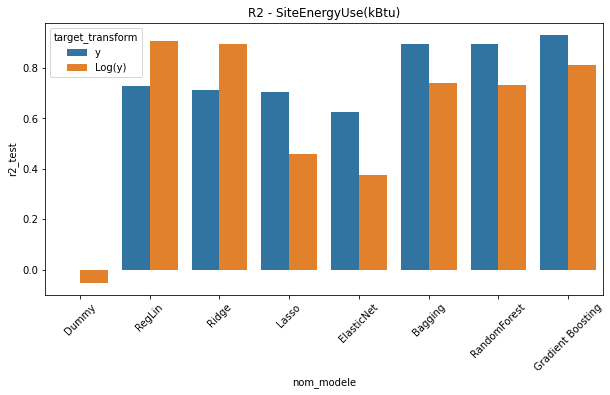

In [195]:
plt.figure(figsize=(10,5))
plot=sns.barplot(x="nom_modele", y="r2_test", hue="target_transform", data=df_score[df_score['target']=='SiteEnergyUse(kBtu)'])
plot.set_title("R2 - SiteEnergyUse(kBtu)")
plt.setp(plot.get_xticklabels(), rotation=45)
plt.show()

In [196]:
df_score[df_score['target']=='SiteEnergyUse(kBtu)'].sort_values(by='rmse_test', ascending=True).head(5)

,nom_modele,target,target_transform,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
28,Gradient Boosting,SiteEnergyUse(kBtu),y,"(n_estim, 2000, - max_depth, 3, - min_impurity...",0.634331,1.482951e+07,0.929548,6.279025e+06,1104.165163,33.723779,0.160626,33.884405
5,RegLin,SiteEnergyUse(kBtu),Log(y),Log(y),0.614162,1.484360e+07,0.906225,7.244157e+06,NaN,0.228684,0.030305,0.258990
9,Ridge,SiteEnergyUse(kBtu),Log(y),"(alpha, 0.8, Log(y))",0.624592,1.463711e+07,0.897376,7.578253e+06,1.890774,0.112933,0.030420,0.143352
20,Bagging,SiteEnergyUse(kBtu),y,"(n_estimators:, 30)",0.621751,1.506088e+07,0.895782,7.636865e+06,37.054937,6.963839,0.071813,7.035653
24,RandomForest,SiteEnergyUse(kBtu),y,"(n_estim, 200, - max_depth, None, - min_impuri...",0.629400,1.485904e+07,0.894802,7.672713e+06,358.246142,45.978173,0.172601,46.150774


### TotalGHGEmissions(MetricTonsCO2e) 

In [197]:
df_score[df_score['target']=='TotalGHGEmissions(MetricTonsCO2e)'].sort_values(by='r2_test', ascending=False).head(5)

,nom_modele,target,target_transform,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
30,Gradient Boosting,TotalGHGEmissions(MetricTonsCO2e),y,"(n_estim, 2000, - max_depth, 3, - min_impurity...",0.575811,410.228158,0.952193,160.775751,1115.399942,32.119838,0.208353,32.328191
22,Bagging,TotalGHGEmissions(MetricTonsCO2e),y,"(n_estimators:, 40)",0.581370,403.861283,0.927506,197.982801,38.122316,9.515751,0.087791,9.603542
31,Gradient Boosting,TotalGHGEmissions(MetricTonsCO2e),Log(y),"(n_estim, 500, - max_depth, 3, - min_impurity_...",0.634617,365.029174,0.918683,209.684519,967.138134,8.168312,0.055865,8.224177
26,RandomForest,TotalGHGEmissions(MetricTonsCO2e),y,"(n_estim, 200, - max_depth, None, - min_impuri...",0.577085,405.295695,0.906621,224.699447,347.796508,42.396591,0.158181,42.554772
11,Ridge,TotalGHGEmissions(MetricTonsCO2e),Log(y),"(alpha, 1.0, Log(y))",0.511793,409.478241,0.847702,286.961400,1.974012,0.105715,0.030936,0.136652


In [198]:
df_score[df_score['target']=='TotalGHGEmissions(MetricTonsCO2e)'].sort_values(by='rmse_test', ascending=True).head(5)

,nom_modele,target,target_transform,commentaires,r2_cv,rmse_cv,r2_test,rmse_test,param_time,fit_time,score_time,time_total
30,Gradient Boosting,TotalGHGEmissions(MetricTonsCO2e),y,"(n_estim, 2000, - max_depth, 3, - min_impurity...",0.575811,410.228158,0.952193,160.775751,1115.399942,32.119838,0.208353,32.328191
22,Bagging,TotalGHGEmissions(MetricTonsCO2e),y,"(n_estimators:, 40)",0.581370,403.861283,0.927506,197.982801,38.122316,9.515751,0.087791,9.603542
31,Gradient Boosting,TotalGHGEmissions(MetricTonsCO2e),Log(y),"(n_estim, 500, - max_depth, 3, - min_impurity_...",0.634617,365.029174,0.918683,209.684519,967.138134,8.168312,0.055865,8.224177
26,RandomForest,TotalGHGEmissions(MetricTonsCO2e),y,"(n_estim, 200, - max_depth, None, - min_impuri...",0.577085,405.295695,0.906621,224.699447,347.796508,42.396591,0.158181,42.554772
11,Ridge,TotalGHGEmissions(MetricTonsCO2e),Log(y),"(alpha, 1.0, Log(y))",0.511793,409.478241,0.847702,286.961400,1.974012,0.105715,0.030936,0.136652


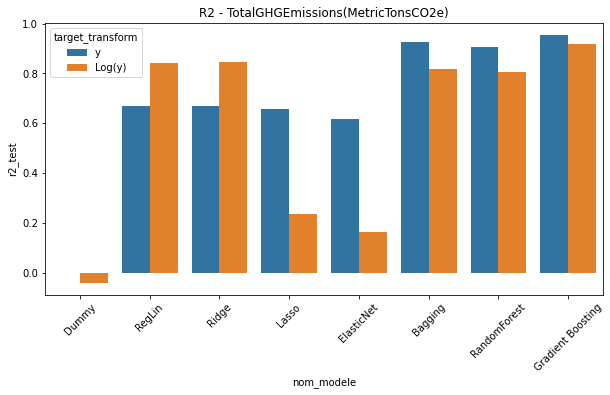

In [199]:
plt.figure(figsize=(10,5))
plot=sns.barplot(x="nom_modele", y="r2_test", hue="target_transform", data=df_score[df_score['target']=='TotalGHGEmissions(MetricTonsCO2e)'])
plot.set_title("R2 - TotalGHGEmissions(MetricTonsCO2e)")
plt.setp(plot.get_xticklabels(), rotation=45)
plt.show()

## E.2 - Performances matérielles : temps d'éxecution <a name=E.2></a>
On va maintenant s'interresser aux performances en terme de temps d'éxecution, que ce soit le temps de recherche des paramètres optimaux ou le temps d'entrainement et de prédiction.
### Temps d'optimisation des paramètres

In [200]:
def modalMeans(df, vQuanti, vQuali):
    tabmoda = moda(df, vQuali)[vQuali]
    dfmeans=pd.DataFrame(tabmoda)
    nomcol='mean '+vQuanti
    dfmeans.insert(1,nomcol,0)
    for i in tabmoda:
        dfmeans[nomcol][dfmeans[vQuali]==i]=df[vQuanti][df[vQuali]==i].mean()
    return dfmeans.sort_values(by=[nomcol],ascending=False).reset_index(drop=True)

In [201]:
tab_mean=modalMeans(df_score,"param_time","nom_modele")
tab_mean

<ipython-input-200-5c1658f9ae01>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmeans[nomcol][dfmeans[vQuali]==i]=df[vQuanti][df[vQuali]==i].mean()


,nom_modele,mean param_time
0,Gradient Boosting,1031.982655
1,RandomForest,263.034015
2,Bagging,36.666953
3,Lasso,6.430226
4,ElasticNet,5.429184
5,Ridge,1.732875
6,Dummy,NaN
7,RegLin,NaN


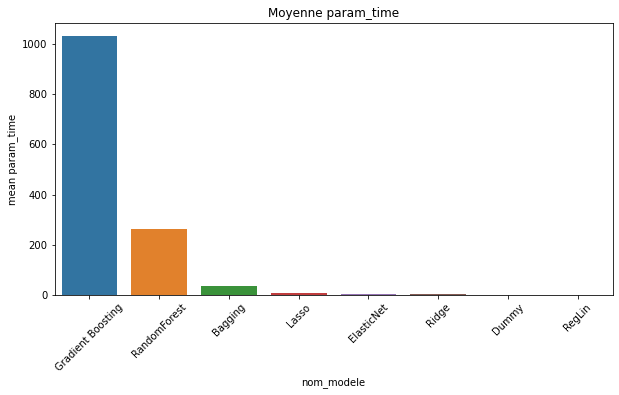

In [202]:
plt.figure(figsize=(10,5))
plot=sns.barplot(x="nom_modele", y="mean param_time", data=tab_mean)
plot.set_title("Moyenne param_time")
plt.setp(plot.get_xticklabels(), rotation=45)
plt.show()

In [203]:
tab_mean['mean param_time'].values/60

array([17.19971092,  4.38390025,  0.61111589,  0.10717043,  0.09048641,
        0.02888124,         nan,         nan])

### Temps de fit & predict 

In [204]:
tab_mean=modalMeans(df_score,"time_total","nom_modele")
tab_mean

<ipython-input-200-5c1658f9ae01>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmeans[nomcol][dfmeans[vQuali]==i]=df[vQuanti][df[vQuali]==i].mean()


,nom_modele,mean time_total
0,RandomForest,43.515742
1,Gradient Boosting,22.748994
2,Bagging,8.499785
3,ElasticNet,0.297103
4,RegLin,0.265980
5,Lasso,0.196598
6,Ridge,0.136664
7,Dummy,0.108222


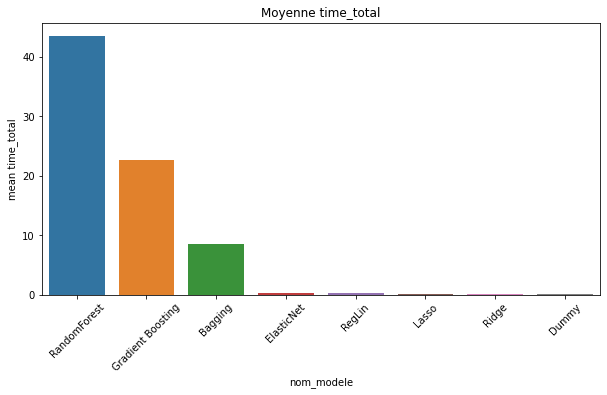

In [205]:
plt.figure(figsize=(10,5))
plot=sns.barplot(x="nom_modele", y="mean time_total", data=tab_mean)
plot.set_title("Moyenne time_total")
plt.setp(plot.get_xticklabels(), rotation=45)
plt.show()

On remarque que les méthodes ensemblistes sont beaucoup plus consommatrice de ressources :
- Fit time :
    - Méthodes ensembliste : de 6 à 61 secondes
    - Autres méthodes : <0.5 secondes
- Score time :
    - Méthodes ensembliste : de 0.06 à 0.16 secondes
    - Autres méthodes : <0.06 secondes

On remarque que la grosse différence se situe sur le fit_time, ou les méthodes ensemblistes prennent beaucoup plus de temps que les autres méthodes. Par contre, le fit_time ne prends pas en compte le temps de la recherche des paramètres optimaux via le GridSearchCV pour les regressions Lasso, Ridge et ElasticNet. 

Le XGBoost, avec une transformation de la target via le log(), semble donc être le meilleur modèle en terme de r2. De plus, même si c'est un modèle qui prends un peut plus de temps à entrainer il reste plus rapide et plus précis que le RandomForest et plus précis qu'une regression Ridge. Même si cette dernière présente est la deuxième méthode la plus précise et beaucoup plus rapide que le XGBoost. 
On va maintenant s'intérresser à l'importance des différentes features dans nos modèles XGBoost pour connaitre les features les plus déterminantes dans nos modèles :

## F - Feature importances <a name=F></a>
### SiteEnergyUse(kBtu)	

In [32]:
model = make_pipeline(preprocessor,GradientBoostingRegressor(n_estimators=2000,
                                                             learning_rate=0.25,
                                                             max_depth=3,
                                                             min_impurity_decrease=0.0,
                                                             random_state=5))
model.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
model.score(X_test, y_test['SiteEnergyUse(kBtu)'])

0.9295476953541619

In [247]:
import joblib
# save the model to disk
filename = 'gboost_energy_use.sav'
joblib.dump(model, filename)
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test['SiteEnergyUse(kBtu)'])
print(result)

0.9295476953541619


In [33]:
ohe_features_names = model['columntransformer'].transformers_[1][1]['onehotencoder'].get_feature_names()
importances = model.named_steps['gradientboostingregressor'].feature_importances_
features_names=np.concatenate([numerical_features,ohe_features_names])

In [34]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(features_names, importances)
df = pd.DataFrame(zipped, columns=["feature", "importance"])
# Sort the features by the absolute value of their coefficient
df = df.sort_values("importance", ascending=False)

Text(0.5, 0, 'Feature Name')

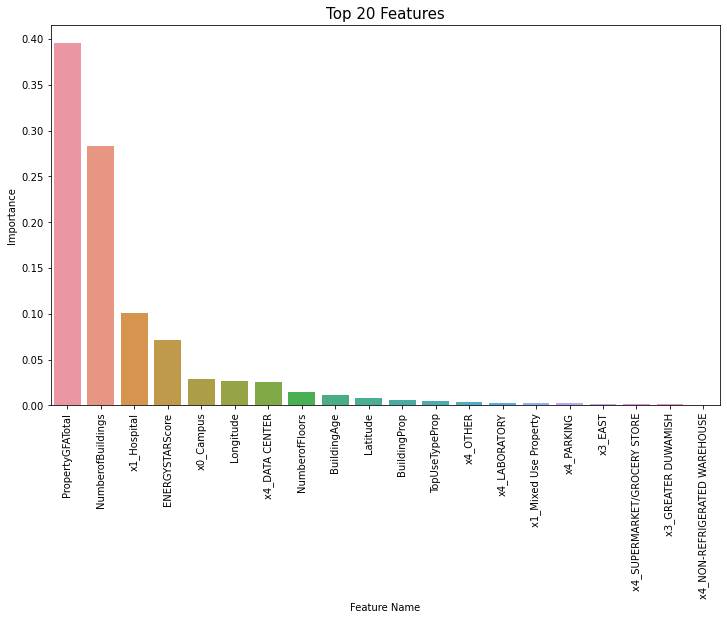

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="importance",
            data=df.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_title("Top 20 Features", fontsize=15)
ax.set_ylabel("Importance", fontsize=10)
ax.set_xlabel("Feature Name", fontsize=10)

In [37]:
import shap

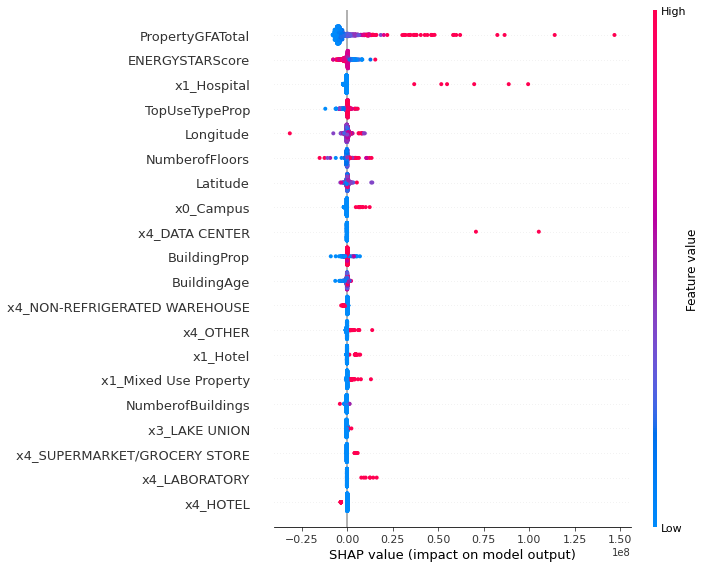

In [38]:
ex = shap.TreeExplainer(model['gradientboostingregressor'])
observations = model['columntransformer'].transform(X_test)
observations=observations.toarray()
df_obs=pd.DataFrame(data=observations, columns=features_names)
df_test =pd.DataFrame(data=model['columntransformer'].transform(X_test).toarray(), columns=features_names)
shap_values = ex.shap_values(df_obs)
shap.summary_plot(shap_values, df_test)

### TotalGHGEmissions(MetricTonsCO2e)

In [39]:
model = make_pipeline(preprocessor,GradientBoostingRegressor(n_estimators=2000,
                                                             learning_rate=0.1,
                                                             max_depth=3,
                                                             min_impurity_decrease=0.0,
                                                             random_state=5))
model.fit(X_train, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])

0.9521934009509252

In [271]:
# save the model to disk
filename = 'gboost_emissions.sav'
joblib.dump(model, filename)
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test['TotalGHGEmissions(MetricTonsCO2e)'])
print(result)

0.9521934009509252


In [40]:
ohe_features_names = model['columntransformer'].transformers_[1][1]['onehotencoder'].get_feature_names()
importances = model.named_steps['gradientboostingregressor'].feature_importances_
features_names=np.concatenate([numerical_features,ohe_features_names])

In [41]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(features_names, importances)
df = pd.DataFrame(zipped, columns=["feature", "importance"])
# Sort the features by the absolute value of their coefficient
df = df.sort_values("importance", ascending=False)

Text(0.5, 0, 'Feature Name')

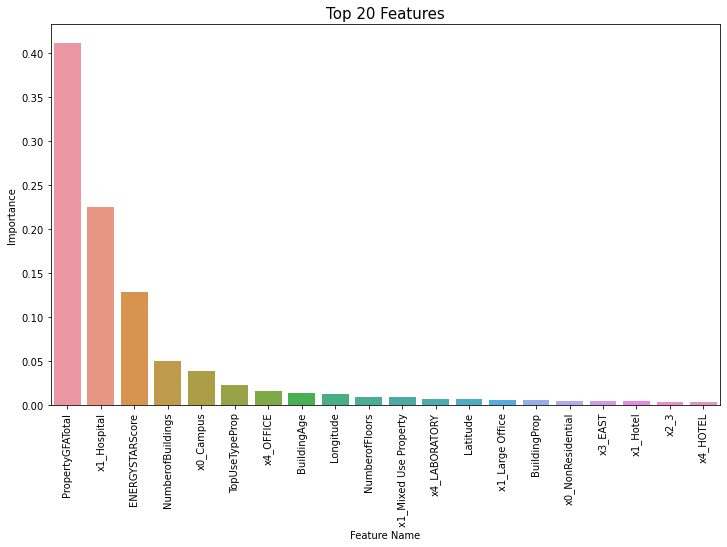

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="importance",
            data=df.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_title("Top 20 Features", fontsize=15)
ax.set_ylabel("Importance", fontsize=10)
ax.set_xlabel("Feature Name", fontsize=10)

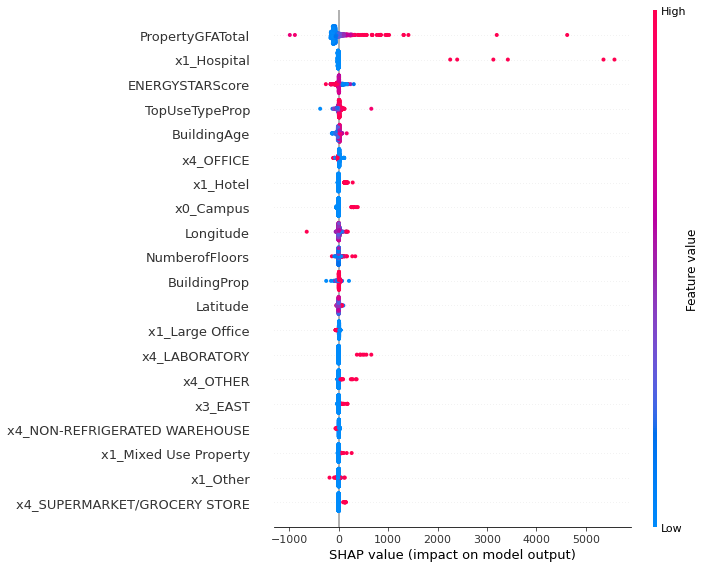

In [275]:
ex = shap.TreeExplainer(model['gradientboostingregressor'])
observations = model['columntransformer'].transform(X_test)
observations=observations.toarray()
df_obs=pd.DataFrame(data=observations, columns=features_names)
df_test =pd.DataFrame(data=model['columntransformer'].transform(X_test).toarray(), columns=features_names)
shap_values = ex.shap_values(df_obs)
shap.summary_plot(shap_values, df_test)

## G - Performances sans 'ENERGYSTARScore' <a name=G></a>

In [263]:
X_train_2 = X_train.drop(columns=['ENERGYSTARScore'])
X_test_2 = X_test.drop(columns=['ENERGYSTARScore'])

In [266]:
numerical_features_2 = ['Latitude','Longitude','BuildingAge','NumberofBuildings','NumberofFloors','PropertyGFATotal','BuildingProp','TopUseTypeProp']

In [267]:
preprocessor_2=make_column_transformer((numerical_pipeline, numerical_features_2),(categorical_pipeline, categorical_features))
preprocessor_log_2=make_column_transformer((numerical_pipeline, numerical_features_log_2),(categorical_pipeline, categorical_features))

### TotalGHGEmissions(MetricTonsCO2e)

In [268]:
model = make_pipeline(preprocessor_2,GradientBoostingRegressor(n_estimators=2000,
                                                             learning_rate=0.25,
                                                             max_depth=3,
                                                             min_impurity_decrease=0.0,
                                                             random_state=5))
model.fit(X_train_2, y_train['SiteEnergyUse(kBtu)'])
model.score(X_test_2, y_test['SiteEnergyUse(kBtu)'])

0.9504408451114349

### SiteEnergyUse(kBtu)

In [269]:
model = make_pipeline(preprocessor_2,GradientBoostingRegressor(n_estimators=2000,
                                                             learning_rate=0.1,
                                                             max_depth=3,
                                                             min_impurity_decrease=0.0,
                                                             random_state=5))
model.fit(X_train_2, y_train['TotalGHGEmissions(MetricTonsCO2e)'])
model.score(X_test_2, y_test['TotalGHGEmissions(MetricTonsCO2e)'])

0.9657118542022046